https://stackoverflow.com/questions/77587951/how-to-fit-a-system-of-odes-with-interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

In [2]:
def system(t, x, k0, k1, k2, p1, p2):
    return np.array([
        -k0 * x[0],
        p1 * x[0] - k1 * x[1],
        p2 * x[1] - k2 * x[2]
    ])

In [3]:
def solver(parameters, t=np.linspace(0, 1, 10)):
    x0 = parameters[-3:]
    parameters = parameters[:-3]
    solution = integrate.solve_ivp(system, [t.min(), t.max()], x0, args=parameters, t_eval=t)
    return solution.y

In [4]:
texp = np.linspace(0, 35, 10)
#p0 = np.array([ 0.03693555,  0.38054633, -0.06252069,  1.41453107, -0.11159681])
p0 = np.array([ 0.1, 0.3, 1, 1.2, 0.9, 0.5, 1., 0.8])

In [5]:
xexp = solver(p0, t=texp)
xexp += 0.05 * np.random.normal(size=xexp.shape)

In [6]:
def residuals_factory(t, x):
    def wrapped(parameters):
        return 0.5 * np.sum(np.power(x - solver(parameters, t=t), 2))
    return wrapped

In [7]:
residuals = residuals_factory(texp, xexp)
solution = optimize.minimize(
    residuals, x0=[1, 1, 1, 1, 1, 1, 1, 1],
    bounds=[(0, np.inf)]*8
)

In [8]:
solution

      fun: 0.019802451367366164
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.77605500e-04, -5.86246330e-05,  6.94375109e-06,  8.47932840e-06,
       -1.63074414e-05,  3.34347133e-05,  4.08631460e-06,  4.16368327e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 720
      nit: 62
     njev: 80
   status: 0
  success: True
        x: array([0.09428973, 0.39158086, 0.66722838, 1.72023949, 0.58265682,
       0.4507214 , 0.99891956, 0.75883089])

In [9]:
p0

array([0.1, 0.3, 1. , 1.2, 0.9, 0.5, 1. , 0.8])

In [10]:
tlin = np.linspace(texp.min(), texp.max(), 200)
xhat = solver(solution.x, t=tlin)

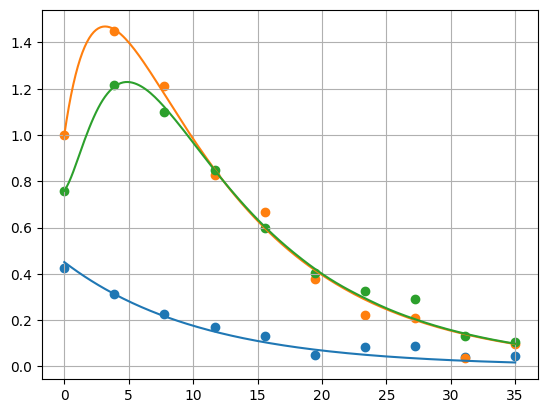

In [11]:
fig, axe = plt.subplots()
for i in range(xexp.shape[0]):
    axe.scatter(texp, xexp[i, :])
    axe.plot(tlin, xhat[i, :])
axe.grid()